In [1]:
import sys
import os

sys.path.append('/home/profes/miriamgf/tesis/Autoencoders/code/egm_reconstruction/Code/')


from config import TrainConfig_1
from config import TrainConfig_2
from config import DataConfig
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tools_ import freq_phase_analysis as freq_pha
from tools_ import plots
from tools_.preprocessing_network import *
from tools_.tools import *
from tools_.df_mapping import *
import tensorflow as tf
import os
import scipy
import datetime
import time
from evaluate_function import *
from numpy import *
import pickle
import sys
import mlflow
import itertools
from scipy.signal import find_peaks


sys.path.append('/code')
tf.random.set_seed(42)

root_logdir = '../output/logs/'
log_dir = root_logdir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
data_dir = '/home/profes/miriamgf/tesis/Autoencoders/Data/'
torsos_dir = '/home/profes/miriamgf/tesis/Autoencoders/Labeled_torsos/'
figs_dir = '../output/'
models_dir = '../output/model/'
dict_var_dir = '../output/variables/'
dict_results_dir = '../output/results/'


dic_vars = {}
dict_results = {}

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

start = time.time()

all_torsos_names = []
for subdir, dirs, files in os.walk(torsos_dir):
    for file in files:
        if file.endswith('.mat'):
            all_torsos_names.append(file)


all_model_names = []
directory = data_dir
for subdir, dirs, files in os.walk(directory):
    #print(subdir, directory, files)

    if (subdir != directory):
        model_name = subdir.split("/")[-1]
        all_model_names.append(model_name)


#Load data
df = load_egms_df(data_dir)
df= df.sort_values(by='id')
df.head(10)



2024-05-29 09:47:11.905348: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 09:47:11.936183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:47:11.936201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:47:11.937082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 09:47:11.942541: I tensorflow/core/platform/cpu_feature_guar

Num GPUs: 2
data ['Simulation_01_200316_001_  7', 'Simulation_01_200212_001_  2', 'Simulation_01_210209_001_002', 'Simulation_01_210205_001_002', 'LA_RSPV_CAF_150115', 'Simulation_01_200428_001_001', 'Simulation_01_200316_001_  5', 'Simulation_01_191001_001_002', 'Simulation_01_200428_001_005', 'Simulation_01_190717_001_001', 'Simulation_01_200212_001_  7', 'Simulation_01_191001_001_007', 'LA_RSPV_150113', 'Simulation_01_210119_001_001', 'Simulation_01_210205_001_003', 'LA_PLAW_140612', 'Simulation_01_190717_001_004', 'Simulation_01_201223_001_002', 'Simulation_01_200212_001_  1', 'LA_LSPV_150203', 'Simulation_01_190619_001_003', 'Simulation_01_200428_001_003', 'Simulation_01_190619_001_004', 'Simulation_01_190717_001_003', 'Simulation_01_190502_001_006', 'LA_LSPV_150113', 'Simulation_01_190502_001_004', 'RA_RAFW_140807', 'Simulation_01_190717_001_002', 'Simulation_01_200316_001_  3', 'Simulation_01_200316_001_  4', 'RA_RAA_141230', 'Sinusal_150629', 'RA_RAA_141216', 'Simulation_01_200

,id,AF_signal
65,LA_LIPV_150119,"[[-0.006205437284980766, -1.4475650662061534, ..."
25,LA_LSPV_150113,"[[-0.7462473339799057, -0.4222642805233415, -0..."
19,LA_LSPV_150203,"[[-1.5901741637349136, -1.5606660583768013, -1..."
15,LA_PLAW_140612,"[[-0.8227917880841811, -0.7746437955997634, -0..."
53,LA_PLAW_140711_arm,"[[0.522990608582245, 0.5108930949270666, 0.498..."
61,LA_RIPV_150121,"[[-9.238636672893737, -10.30493224107485, -11...."
12,LA_RSPV_150113,"[[-13.181415211442266, -30.010355928989465, -4..."
4,LA_RSPV_CAF_150115,"[[7.387776530722087, 9.094867906767199, 10.800..."
33,RA_RAA_141216,"[[-1.8483425750409432, -1.5997689835539015, -1..."
31,RA_RAA_141230,"[[-1.5399639907851848, -1.421404688195314, -1...."


In [9]:
bsps_list=[]
for i in range(0,df.shape[0]):
   
    id_1 = df['id'][i]
    sig1 = np.array(df['AF_signal'][df['id'] == id_1])
    sig=sig1[0][0, :]
    peaks, _ = find_peaks(sig, height=0, distance=80)

    t=len(sig)/fs
    bpm=(len(peaks)*60)/t
    bsps_list.append(bpm)
    '''
    plt.figure(figsize=(6,2),tight_layout=True)
    plt.plot(sig)
    plt.plot(peaks, sig[peaks], "x")
    plt.title(id_1 + '   bpm:'+ str(bpm))
    plt.show()
    '''


df['bsps']=bsps_list

    


In [7]:
bsps_list

[329.8350824587706,
 239.94667851588534,
 200.0,
 200.0,
 312.124849939976,
 345.8877786318217,
 329.8350824587706,
 259.9422350588758,
 329.8350824587706,
 259.9422350588758,
 329.8350824587706,
 259.9422350588758,
 270.0,
 240.0,
 200.0,
 270.0,
 266.60742057320596,
 240.0,
 329.8350824587706,
 270.0,
 255.0,
 329.8350824587706,
 255.0,
 253.27704954454563,
 247.5,
 288.11524609843934,
 247.5,
 285.0,
 257.8602126215788,
 329.8350824587706,
 226.61630748722504,
 300.0,
 84.03361344537815,
 240.09603841536614,
 260.45777426992896,
 209.79020979020981,
 209.79020979020981,
 255.0,
 329.8350824587706,
 329.8350824587706,
 239.94667851588534,
 233.2814930015552,
 239.94667851588534,
 239.94667851588534,
 259.9422350588758,
 329.8350824587706,
 194.9025487256372,
 226.61630748722504,
 247.5,
 252.10084033613444,
 266.60742057320596,
 247.5,
 226.61630748722504,
 180.0,
 233.2814930015552,
 192.0768307322929,
 233.2814930015552,
 247.5,
 239.94667851588534,
 329.8350824587706,
 200.0,
 270

In [5]:
df.head()

,id,AF_signal,bpms
65,LA_LIPV_150119,"[[-0.006205437284980766, -1.4475650662061534, ...",329.835082
25,LA_LSPV_150113,"[[-0.7462473339799057, -0.4222642805233415, -0...",239.946679
19,LA_LSPV_150203,"[[-1.5901741637349136, -1.5606660583768013, -1...",200.000000
15,LA_PLAW_140612,"[[-0.8227917880841811, -0.7746437955997634, -0...",200.000000
53,LA_PLAW_140711_arm,"[[0.522990608582245, 0.5108930949270666, 0.498...",312.124850


IndexError: invalid index to scalar variable.

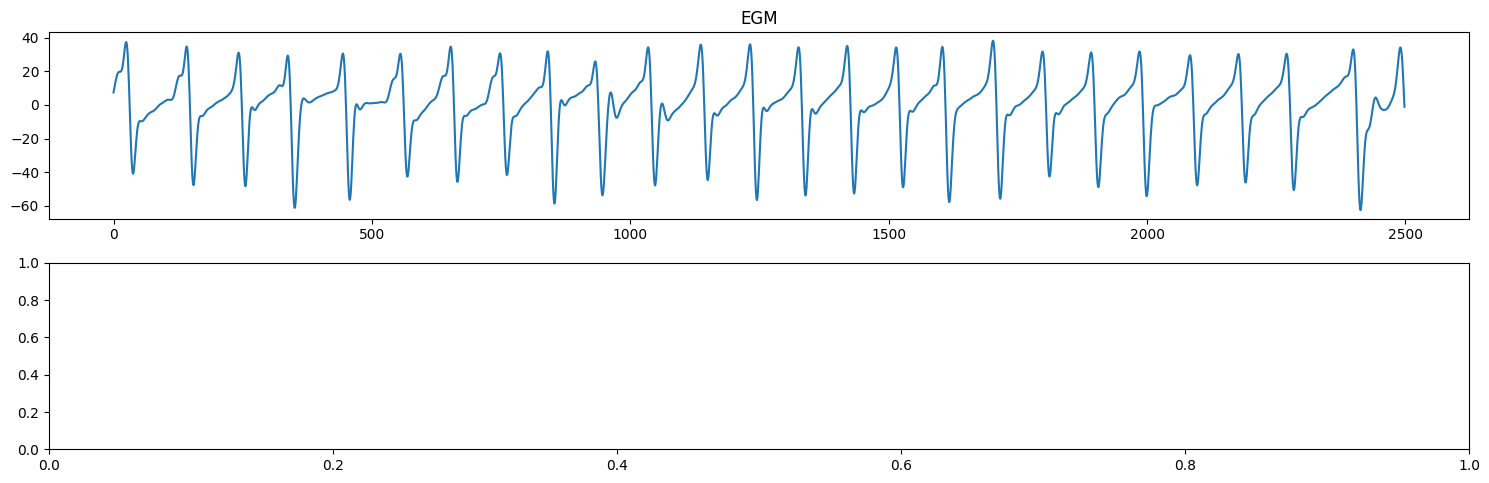

In [14]:
id_1 = 'LA_RSPV_CAF_150115'
id_2 = 'Simulation_01_190619_001_002'
id_3 = 'Simulation_01_200212_001_  8'
EGM_1 = np.array(df['AF_signal'][df['id'] == id_1])
BSPM_1 = np.array(df['bsps'][df['id'] == id_1])
sig3 = np.array(df['AF_signal'][df['id'] == id_3])


plt.figure(figsize=(15,7),tight_layout=True)
plt.subplot(3, 1, 1)
plt.plot(EGM_1[0][0, :])
plt.title('EGM')
plt.subplot(3, 1, 2)
plt.plot(BSPM_1[0][0, :])
plt.title(' BSPS')
plt.subplot(3, 1, 3)
plt.plot(sig3[0][0, :])
plt.title(id_3)
plt.show()